In [67]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
%matplotlib inline
sns.set()

In [68]:
print(os.listdir('../FinalWork/berlin-airbnb-data'))

['reviews.csv', '.DS_Store', 'neighbourhoods.csv', 'listings.csv', 'calendar_summary.csv', 'reviews_summary.csv', '.ipynb_checkpoints', 'listings_summary.csv']


In [69]:
df_reviews = pd.read_csv('../FinalWork/berlin-airbnb-data/reviews.csv')
df_neighbourhoods = pd.read_csv('../FinalWork/berlin-airbnb-data/neighbourhoods.csv')
df_listings = pd.read_csv('../FinalWork/berlin-airbnb-data/listings.csv')
df_calendar_summary = pd.read_csv('../FinalWork/berlin-airbnb-data/calendar_summary.csv')
df_reviews_summary = pd.read_csv('../FinalWork/berlin-airbnb-data/reviews_summary.csv')
df_listings_summary = pd.read_csv('../FinalWork/berlin-airbnb-data/listings_summary.csv')

In [70]:
import warnings
warnings.filterwarnings("ignore")

In [71]:
s2 = '":@.-()/{}'
for row in df_listings_summary.amenities:
    s1 = row
    for sim in s2:
        s1 = s1.replace(str(sim), '')
    R = s1.split(",")

In [72]:
df_listings_summary["amenities"] = df_listings_summary["amenities"].apply(lambda x: x[1:-1].replace("\"", "").split(","))

In [73]:
df_listings_summary["security_deposit"].fillna("$0.00", inplace=True)
df_listings_summary["cleaning_fee"].fillna("$0.00", inplace=True)
df_listings_summary["extra_people"].fillna("$0.00", inplace=True)

In [74]:
def remove_s(str_price):
    if "," in str_price:
        str_price = str_price.replace(",", "")
    else:
        pass
    return str_price[1:]


for s_column in ["price", "security_deposit", "cleaning_fee", "extra_people"]:
    price_no_s = df_listings_summary[s_column].apply(remove_s)
    df_listings_summary[s_column] = price_no_s

In [75]:
df_listings_summary["price"] = df_listings_summary["price"].astype("float")

In [76]:
df_listings_summary["host_is_superhost"].fillna("f", inplace=True)
df_listings_summary["host_identity_verified"].fillna("f", inplace=True)
df_listings_summary["bedrooms"].fillna(1.0, inplace=True)

In [77]:
columns_to_keep = ["id", "description", "neighbourhood_cleansed", "neighbourhood_group_cleansed",
                   "property_type", "room_type", "accommodates", "bathrooms", "bedrooms", "bed_type",
                   "amenities", "square_feet", "price", "security_deposit", "cleaning_fee", "guests_included", 
                   "extra_people", "minimum_nights", "instant_bookable", "cancellation_policy",
                   "host_identity_verified", "is_business_travel_ready", "host_is_superhost", "latitude", "longitude"]

In [78]:
df_selected = df_listings_summary[columns_to_keep].set_index('id')

In [79]:
df_raw = df_selected[(df_selected.price 
                                 <= np.percentile(df_selected["price"],
                                99.5)) & (df_selected.price > 0)]

In [80]:
selected = []
df_raw["is_entire_apt"] = df_raw["room_type"]=="Entire home/apt"
selected.append("is_entire_apt")

In [81]:
df_raw["hair_dryer"] = df_raw["amenities"].apply(lambda x: '"Hair dryer"' in x)
df_raw["lap_friendly"] = df_raw["amenities"].apply(lambda x: '"Laptop friendly workspace"' in x)
df_raw["Washer"] = df_raw["amenities"].apply(lambda x: "Washer" in x)
for i in ["hair_dryer", "lap_friendly", "Washer"]:
    selected.append(i)

In [82]:
df_raw["minimum_nights_more_1"] = df_raw["minimum_nights"].apply(lambda x: 'True' if x > 1 else 'False')
selected.append("minimum_nights_more_1")

In [83]:
df_raw["cleaning_fee"] = df_raw["cleaning_fee"].astype("float")
selected.append("cleaning_fee")

In [84]:
selected.append("accommodates")

In [85]:
selected.append("host_is_superhost")
selected.append("host_identity_verified")
selected.append("instant_bookable")

In [86]:
df_raw["cancellation_not_flexible"] = df_raw["cancellation_policy"]!="flexible"
df_raw["cancellation_not_flexible"].value_counts()


True     13390
False     9051
Name: cancellation_not_flexible, dtype: int64

In [87]:
selected.append("cancellation_not_flexible")

In [88]:
df_raw["host_is_superhost"] = df_raw["host_is_superhost"]=="t"
df_raw["host_identity_verified"] = df_raw["host_identity_verified"]=="t"
df_raw["instant_bookable"] = df_raw["instant_bookable"]=="t"
df_raw["minimum_nights_more_1"] = df_raw["minimum_nights_more_1"]=="t"

In [89]:
lat_long_list = [[52.525293,13.369359],[52.558794,13.288437],[52.516497,13.377683],
                 [52.517693,13.402141],[52.518770,13.376166]]

In [90]:
toploc = {"hbf": [52.525293, 13.369359], 
          "txl": [52.558794, 13.288437], 
          "btor": [52.516497, 13.377683], 
          "museum": [52.517693, 13.402141], 
          "reichstag": [52.518770, 13.376166]}

In [91]:
df_raw["good_location"] = df_raw["neighbourhood_group_cleansed"].apply(lambda x: 'True' if x in ["Mitte", "Friedrichshain-Kreuzberg", "Charlottenburg-Wilm.", "Tempelhof - Schöneberg", "Pankow"] else 'False')

In [92]:
selected.append("good_location")
df_raw["good_location"] = df_raw["good_location"]=="t"

In [93]:
for col in df_raw[selected].select_dtypes("bool").columns:
    df_raw[col] = df_raw[col].astype("int")

In [94]:
# В целях улучшения качества модели попробуем создать дополнительные признаки. 

In [95]:
df_raw['square_feet'].head()

id
2015      NaN
2695      NaN
3176    720.0
3309      0.0
7071      NaN
Name: square_feet, dtype: float64

In [96]:
# В предыдущей модели за размер квартиры отвечала переменная accomodates.
# Попробуем определить размер квартир точнее, например в квадратных метрах
# Колонка square_feet не дает необходимой информации, т.к. содержит много пропущенных значений
df_raw.square_feet.isna().sum()

21996

In [97]:
# Колонка description может содержать информацию о площади
df_raw.description.isna().sum()

202

In [98]:
# Извлечем возможные значения площади
df_raw['size'] = df_raw['description'].str.extract('(\d{2,3}\s?[smSM])', expand=True)
df_raw['size'] = df_raw['size'].str.replace("\D", "")
df_raw['size'] = df_raw['size'].astype(float)

In [99]:
df_raw['size'].isna().sum()

11744

In [100]:
# Не все значения удалось заполнить с помощью текста описания
df_raw[['description', 'size']].head(10)

description   size
id                                                             
2015   Great location!  30 of 75 sq meters. This wood...   75.0
2695   In the summertime we are spending most of our ...   25.0
3176   This beautiful first floor apartment  is situa...   68.0
3309   First of all: I prefer short-notice bookings. ...   26.0
7071   Cozy and large room in the beautiful district ...   20.0
9991   4 bedroom with very large windows and outstand...  780.0
14325  The apartment is located on the upper second f...    NaN
16401  Hello future guests! We want to rent our cute ...   55.0
16644  Light and sunny 2-Room-turn of the century-fla...   80.0
17409  The 25 sqm room is located in the heart of Ber...   25.0

In [101]:
df_raw["security_deposit"] = df_raw["security_deposit"].astype("float")
df_raw["extra_people"] = df_raw["extra_people"].astype("float")

In [102]:
df_raw["bathrooms"].fillna(1.0, inplace=True)
df_raw["bathrooms"].isna().any()

False

In [103]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22441 entries, 2015 to 29867352
Data columns (total 32 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   description                   22239 non-null  object 
 1   neighbourhood_cleansed        22441 non-null  object 
 2   neighbourhood_group_cleansed  22441 non-null  object 
 3   property_type                 22441 non-null  object 
 4   room_type                     22441 non-null  object 
 5   accommodates                  22441 non-null  int64  
 6   bathrooms                     22441 non-null  float64
 7   bedrooms                      22441 non-null  float64
 8   bed_type                      22441 non-null  object 
 9   amenities                     22441 non-null  object 
 10  square_feet                   445 non-null    float64
 11  price                         22441 non-null  float64
 12  security_deposit              22441 non-null  float64


In [104]:
# Чтобы не потерять значительную часть полезной информации, не будем избавляться от пропущенных значений.
# Заполним их значениями, полученными с помощью алгоритма машинного обучения. Для этого используем только численные значения
sub_df = df_raw[['accommodates', 'bathrooms', 'bedrooms',  'price', 'cleaning_fee', 
                 'security_deposit', 'extra_people', 'guests_included', 'good_location', 'size']]

In [105]:
sub_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22441 entries, 2015 to 29867352
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   accommodates      22441 non-null  int64  
 1   bathrooms         22441 non-null  float64
 2   bedrooms          22441 non-null  float64
 3   price             22441 non-null  float64
 4   cleaning_fee      22441 non-null  float64
 5   security_deposit  22441 non-null  float64
 6   extra_people      22441 non-null  float64
 7   guests_included   22441 non-null  int64  
 8   good_location     22441 non-null  int64  
 9   size              10697 non-null  float64
dtypes: float64(7), int64(3)
memory usage: 1.9 MB


In [106]:
sub_df.head()

accommodates  bathrooms  bedrooms  price  cleaning_fee  \
id                                                             
2015             3        1.0       1.0   60.0          30.0   
2695             2        1.0       1.0   17.0           0.0   
3176             4        1.0       1.0   90.0          50.0   
3309             2        1.0       1.0   26.0          30.0   
7071             2        1.0       1.0   42.0           0.0   

      security_deposit  extra_people  guests_included  good_location  size  
id                                                                          
2015             200.0          28.0                1              0  75.0  
2695               0.0           0.0                1              0  25.0  
3176             200.0          20.0                2              0  68.0  
3309             250.0          18.0                1              0  26.0  
7071               0.0          24.0                1              0  20.0

In [107]:
train_data = sub_df[sub_df['size'].notnull()]
test_data  = sub_df[sub_df['size'].isnull()]

In [108]:
X_train = train_data.drop('size', axis=1)
X_test  = test_data.drop('size', axis=1)

In [109]:
y_train = train_data['size']

In [110]:
from sklearn.linear_model import LinearRegression
lg = LinearRegression()
lg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [111]:
y_test = lg.predict(X_test)

In [112]:
# Теперь когда у нас есть значения площади преобразуем y_test в датасет
y_test = pd.DataFrame(y_test)
y_test.columns = ['size']
print(y_test.shape)
y_test.head()

(11744, 1)


size
0  57.080688
1  97.388704
2  74.591018
3  87.394770
4  61.198663

In [113]:
print(X_test.shape)
X_test.head()

(11744, 9)


accommodates  bathrooms  bedrooms  price  cleaning_fee  \
id                                                              
14325             2        1.0       0.0   70.0           0.0   
20858             4        1.0       2.0  129.0          49.0   
21869             4        1.0       1.0   70.0          40.0   
22415             4        1.0       2.0   98.0          50.0   
28156             2        1.0       0.0   70.0           0.0   

       security_deposit  extra_people  guests_included  good_location  
id                                                                     
14325             500.0           0.0                1              0  
20858             500.0          24.0                2              0  
21869             500.0          18.0                2              0  
22415             300.0          25.0                2              0  
28156            1660.0           0.0                1              0

In [114]:
# Чтобы объединить X_test и y_test нужно сопоставить индексы обеих частей
ind = pd.DataFrame(X_test.index)
ind.columns = ['ind']
y_test = pd.concat([y_test, ind], axis=1)
y_test.set_index(['ind'], inplace=True)
y_test.head()

size
ind             
14325  57.080688
20858  97.388704
21869  74.591018
22415  87.394770
28156  61.198663

In [115]:
new_test_data = pd.concat([X_test, y_test], axis=1)

In [116]:
print(new_test_data.shape)
new_test_data.head(10)

(11744, 10)


accommodates  bathrooms  bedrooms  price  cleaning_fee  \
14325             2        1.0       0.0   70.0           0.0   
20858             4        1.0       2.0  129.0          49.0   
21869             4        1.0       1.0   70.0          40.0   
22415             4        1.0       2.0   98.0          50.0   
28156             2        1.0       0.0   70.0           0.0   
31440             1        1.0       1.0   44.0          15.0   
38296             2        1.0       1.0   80.0          35.0   
41217             2        1.0       1.0   43.0           0.0   
41306             2        1.0       1.0   40.0           0.0   
43123             4        1.0       1.0   90.0          50.0   

       security_deposit  extra_people  guests_included  good_location  \
14325             500.0           0.0                1              0   
20858             500.0          24.0                2              0   
21869             500.0          18.0                2              0   
22415             300.0          25.0                2              0   
28156            1660.0           0.0                1              0   
31440             100.0          15.0                1              0   
38296             500.0           0.0                2              0   
41217               0.0          13.0                1              0   
41306               0.0           0.0                1              0   
43123             300.0          20.0                2              0   

            size  
14325  57.080688  
20858  97.388704  
21869  74.591018  
22415  87.394770  
28156  61.198663  
31440  54.376603  
38296  64.519666  
41217  52.712908  
41306  45.614047  
43123  82.595159

In [117]:
new_test_data['size'].isna().sum()

0

In [118]:
sub_df_new = pd.concat([new_test_data, train_data], axis=0)

In [119]:
print(sub_df_new.shape)
sub_df_new.head()

(22441, 10)


accommodates  bathrooms  bedrooms  price  cleaning_fee  \
14325             2        1.0       0.0   70.0           0.0   
20858             4        1.0       2.0  129.0          49.0   
21869             4        1.0       1.0   70.0          40.0   
22415             4        1.0       2.0   98.0          50.0   
28156             2        1.0       0.0   70.0           0.0   

       security_deposit  extra_people  guests_included  good_location  \
14325             500.0           0.0                1              0   
20858             500.0          24.0                2              0   
21869             500.0          18.0                2              0   
22415             300.0          25.0                2              0   
28156            1660.0           0.0                1              0   

            size  
14325  57.080688  
20858  97.388704  
21869  74.591018  
22415  87.394770  
28156  61.198663

In [120]:
df_raw.drop(['accommodates', 'bathrooms', 'bedrooms',  'price', 'cleaning_fee', 
                 'security_deposit', 'extra_people', 'guests_included', 'good_location', 'size'], 
            axis=1, inplace=True)

In [121]:
df = pd.concat([sub_df_new, df_raw], axis=1)

print(df.shape)
df.head(2)

(22441, 32)


accommodates  bathrooms  bedrooms  price  cleaning_fee  \
2015             3        1.0       1.0   60.0          30.0   
2695             2        1.0       1.0   17.0           0.0   

      security_deposit  extra_people  guests_included  good_location  size  \
2015             200.0          28.0                1              0  75.0   
2695               0.0           0.0                1              0  25.0   

      ... is_business_travel_ready host_is_superhost   latitude  longitude  \
2015  ...                        f                 1  52.534537  13.402557   
2695  ...                        f                 0  52.548513  13.404553   

     is_entire_apt hair_dryer lap_friendly  Washer  minimum_nights_more_1  \
2015             1          0            0       0                      0   
2695             0          0            0       1                      0   

      cancellation_not_flexible  
2015                          1  
2695                          0  

[2 rows x 32 columns]

In [122]:
df['size'].describe()

count    22441.000000
mean        60.123550
std         80.870854
min          0.000000
25%         25.000000
50%         49.087384
75%         65.000000
max        980.000000
Name: size, dtype: float64

In [123]:
print(format(np.percentile(df["size"], 98.5)))

300.0


In [124]:
# 98,5% данных ограничиваются площадью 300 кв м. Все что больше 300 кв м, а так же  нулевые значения считаем выбросами. 
df.drop(df[ (df['size'] == 0.) | (df['size'] > 300.) ].index, axis=0, inplace=True)

In [125]:
selected.append("size")

In [126]:
df[selected].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22008 entries, 2015 to 29867352
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   is_entire_apt              22008 non-null  int64  
 1   hair_dryer                 22008 non-null  int64  
 2   lap_friendly               22008 non-null  int64  
 3   Washer                     22008 non-null  int64  
 4   minimum_nights_more_1      22008 non-null  int64  
 5   cleaning_fee               22008 non-null  float64
 6   accommodates               22008 non-null  int64  
 7   host_is_superhost          22008 non-null  int64  
 8   host_identity_verified     22008 non-null  int64  
 9   instant_bookable           22008 non-null  int64  
 10  cancellation_not_flexible  22008 non-null  int64  
 11  good_location              22008 non-null  int64  
 12  size                       22008 non-null  float64
dtypes: float64(2), int64(11)
memory usage: 2

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
scaledFeatures = sc.fit_transform(df[selected])

X = scaledFeatures
y = df["price"]

In [127]:
from sklearn.preprocessing import PolynomialFeatures

In [128]:
trans = PolynomialFeatures(degree=3)
PolyFeatures = trans.fit_transform(df[selected])

In [129]:
X = PolyFeatures
y = df["price"]

In [130]:
from xgboost import plot_importance
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [1]:
from sklearn import metrics

In [3]:
 pip install shap

     |████████████████████████████████| 356 kB 165 kB/s eta 0:00:01
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-macosx_10_9_x86_64.whl size=415793 sha256=feedaf5724c4d6b3975ea2eac7ec2c6fafaa990fbc7746585b4b365dcd972e89
  Stored in directory: /Users/olgakhamtsova/Library/Caches/pip/wheels/ca/25/8f/6ae5df62c32651cd719e972e738a8aaa4a87414c4d2b14c9c0
Successfully built shap
Note: you may need to restart the kernel to use updated packages.


In [72]:
import sklearn
import shap
import time

In [85]:
X_train_summary = shap.kmeans(X_train, 10)

In [86]:
ex = shap.KernelExplainer(lin_regr.predict, X_train_summary)

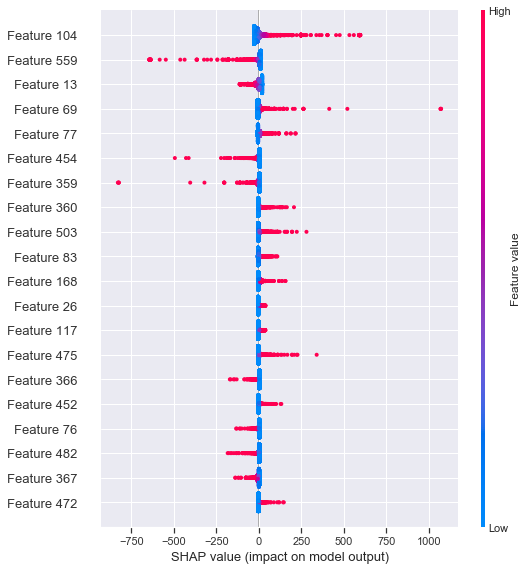

In [88]:
shap_values = ex.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

# 2 svr

In [69]:
import matplotlib.pyplot as plt

In [135]:
from sklearn.svm import SVR

In [136]:
#SVR
regressor = SVR(kernel='rbf')
regressor.fit(X_train, y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [137]:
y_pred2 = regressor.predict(X_test)

In [138]:
RMSE_svr = np.sqrt(mean_squared_error(y_test, y_pred2))
mae_svr = metrics.mean_absolute_error(y_test, y_pred2)
print("R^2 score: {0: .4f}".format(r2_score(y_test, y_pred2)))
print(f"RMSE: {round(RMSE_svr, 4)}")
print("MAE:",mae_svr)

R^2 score:  0.3059
RMSE: 35.4302
MAE: 21.001284931042687


# 2 RandomForest

In [139]:
#RandomForest
from sklearn.ensemble import RandomForestClassifier

# Создаём модель леса из сотни деревьев
model = RandomForestClassifier(n_estimators=100, 
                               bootstrap = True,
                               max_features = 'sqrt')

model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [140]:
# Действующая классификация
rf_predictions = model.predict(X_test)
# Вероятности для каждого класса
rf_probs = model.predict_proba(X_test)[:, 1]

In [141]:
from sklearn.metrics import mean_squared_error, r2_score
RMSE = np.sqrt(mean_squared_error(y_test, rf_predictions))
mae = metrics.mean_absolute_error(y_test, rf_predictions)
print("R^2 score: {0: .4f}".format(r2_score(y_test, rf_predictions)))
print(f"RMSE: {round(RMSE, 4)}")
print("MAE:",mae)

R^2 score:  0.2737
RMSE: 36.2428
MAE: 19.67681356958958


# 2 xgboost

In [77]:
import xgboost as xgb

In [78]:
from xgboost import plot_importance
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error

In [79]:
xgb_clf = xgb.XGBRegressor()
parameters = {'n_estimators': [120, 100, 140], 'max_depth':[3,5,7,9]}
grid_search = GridSearchCV(estimator=xgb_clf, param_grid=parameters, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)

KeyboardInterrupt: 

In [80]:
xgb_clf = xgb.XGBRegressor(n_estimators=140, max_depth=5)
xgb_clf.fit(X_train, y_train)
y_test_pred = xgb_clf.predict(X_test)
print("R^2 score: {0: .4f}".format(r2_score(y_test, y_test_pred)))
print("RMSE: {0: .4f}".format(np.sqrt(mean_squared_error(y_test, y_test_pred))))
mae = metrics.mean_absolute_error(y_test, y_test_pred)
print("MAE:",mae)

[18:15:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
R^2 score:  0.5960
RMSE:  27.0310
MAE: 15.701636137464778


In [82]:
df.shape

(22008, 32)